In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import randn, sample
from scipy import interpolate
from scipy.interpolate import UnivariateSpline
from numpy import linspace


In [2]:
#Clothoid approximation formula based on 
#http://www.dgp.toronto.edu/~mccrae/projects/clothoid/sbim2008mccrae.pdf


def Rt(t):
    return (0.506*t + 1)/(1.79*t*t+ 2.054 *t + np.sqrt(2))
    
def At(t):
    return 1/(0.803*t*t*t + 1.886*t*t + 2.524*t + 2)
    
def Ct(t):
    return 0.5 - Rt(t)*np.sin(0.5*np.pi*(At(t)-t*t))
    
def St(t):
    return 0.5 - Rt(t)*np.cos(0.5*np.pi*(At(t)-t*t))
    

In [3]:
Rt(0)

0.70710678118654746

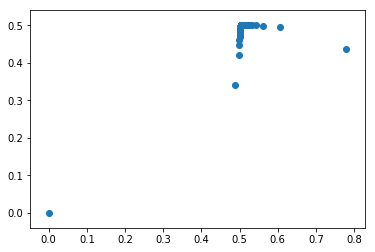

In [4]:
total_len = 100
Ct_axis = []
St_axis = []
for i in range(0, total_len):
    Ct_axis.append(Ct(i))
    St_axis.append(St(i))

plt.scatter(Ct_axis, St_axis)
plt.show()

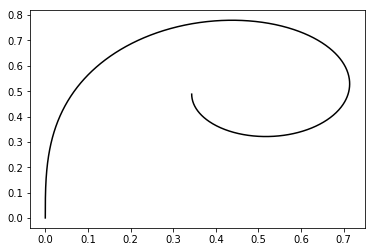

In [5]:
import numpy as np
from scipy.special import fresnel
import pylab
t = np.linspace(0, 2, 1000)
pylab.plot(*fresnel(t), c='k')
pylab.show()

/Users/jonathan/anaconda2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


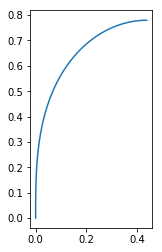

In [6]:
#clothoid with length = 1 m

t = linspace(0, 1, 100)
x, y = fresnel(t)
plt.plot(x, y)
plt.axes().set_aspect("equal")
plt.show()

In [7]:
x.shape

(100,)

In [8]:
a1 = np.column_stack((x,y))
a1.shape

(100, 2)

/Users/jonathan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:119: RuntimeWarning: divide by zero encountered in divide
/Users/jonathan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:119: RuntimeWarning: invalid value encountered in multiply


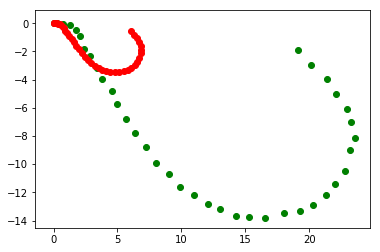

In [9]:
# %load path.py
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import fresnel
from numpy import linspace


class Path(object):
    def __init__(self, path_coordinates):
        self.a = path_coordinates
        self.velocity, self.acceleration, self.t_component, self.n_component\
            , self.curvature, self.speed, self.d2x_dt2, self.d2y_dt2 = self.get_acceleration()

    def plot_curvature(self):

        #plt.axes().set_aspect("equal")

        fig = plt.figure()
        fig.suptitle('curvature', fontsize=14, fontweight='bold')
        plt.scatter(self.a[:, 0], self.a[:, 1])
        # annotate with the curvature at each sample point
        for i, txt in enumerate(self.curvature):
            plt.annotate(str(txt)[0:5], (self.a[i, 0], self.a[i, 1]))
        plt.show()

    def plot_speed(self):
        fig = plt.figure()
        fig.suptitle('speed', fontsize=14, fontweight='bold')
        plt.scatter(self.a[:, 0], self.a[:, 1])

        for i, txt in enumerate(self.speed):
            plt.annotate(str(txt)[0:5], (self.a[i, 0], self.a[i, 1]))
        plt.show()

    def plot_IMU_simulation(self, co_var=0.05):
        x_prime_vec, y_prime_vec = self.get_simulated_path_from_acceleration(Dt=1, co_var=co_var)

        fig = plt.figure()
        fig.suptitle('IMU dead reckoning', fontsize=14, fontweight='bold')
        plt.scatter(self.a[:, 0], self.a[:, 1], color='g')
        plt.scatter(x_prime_vec, y_prime_vec, color='r')
        # plt.scatter(x_pred_vec, y_pred_vec, color='b')
        plt.show()

        #plotting the errors with the path
        error_vec_x = np.array(self.a[:, 0] - np.array(x_prime_vec))
        error_vec_y = np.array(self.a[:, 1] - np.array(y_prime_vec))
        error_vec_a = np.sqrt(error_vec_x * error_vec_x + error_vec_y * error_vec_y)
        number_of_samples = self.a.shape[0]

        fig = plt.figure()
        fig.suptitle('IMU dead reckoning errors along the path', fontsize=14, fontweight='bold')
        plt.scatter(range(0, number_of_samples), error_vec_a)
        plt.show()

    def plot_IMU_errors(self, Monte_Carlo = 100, co_var=0.05):

        max_errors_2 = []
        mc_times = Monte_Carlo
        for i in range(1, mc_times):
            x_prime_vec, y_prime_vec = self.get_simulated_path_from_acceleration(Dt=1, co_var=co_var)
            error_vec_x = np.array(self.a[:, 0] - np.array(x_prime_vec))
            error_vec_y = np.array(self.a[:, 1] - np.array(y_prime_vec))
            error_vec_a = np.sqrt(error_vec_x * error_vec_x + error_vec_y * error_vec_y)
            max_errors_2.append(max(error_vec_a))

        fig = plt.figure()
        fig.suptitle('IMU dead reckoning positioning errors (in meters)', fontsize=14, fontweight='bold')
        plt.scatter(range(1, mc_times), max_errors_2)
        plt.show()

        return max_errors_2

    def get_acceleration(self):
        '''
        input: a is the x,y coordinates of a numpy array of a path sampled with a given time interval
        for example:
        array([[  0.  ,   0.  ],
       [  0.3 ,   0.  ],
       [  1.25,  -0.1 ],
       [  2.1 ,  -0.9 ],
       [  2.85,  -2.3 ],
       [  3.8 ,  -3.95],
       [  5.  ,  -5.75],
       [  6.4 ,  -7.8 ],
       [  8.05,  -9.9 ],
       [  9.9 , -11.6 ],
       [ 12.05, -12.85],
       [ 14.25, -13.7 ],
       [ 16.5 , -13.8 ],
       [ 19.25, -13.35],
       [ 21.3 , -12.2 ],
       [ 22.8 , -10.5 ],
       [ 23.55,  -8.15],
       [ 22.95,  -6.1 ],
       [ 21.35,  -3.95],
       [ 19.1 ,  -1.9 ]])
        :return:
        '''
        a = self.a
        dx_dt = np.gradient(a[:, 0])
        dy_dt = np.gradient(a[:, 1])
        velocity = np.array([ [dx_dt[i], dy_dt[i]] for i in range(dx_dt.size)])
        ds_dt = np.sqrt(dx_dt * dx_dt + dy_dt * dy_dt)

        speed = ds_dt
        # tangent is the direction of the velocity vector, while speed is the magnitude of the velocity vector

        tangent = np.array([1 / ds_dt] * 2).transpose() * velocity
        tangent_x = tangent[:, 0]
        tangent_y = tangent[:, 1]

        deriv_tangent_x = np.gradient(tangent_x)
        deriv_tangent_y = np.gradient(tangent_y)

        dT_dt = np.array([[deriv_tangent_x[i], deriv_tangent_y[i]] for i in range(deriv_tangent_x.size)])

        length_dT_dt = np.sqrt(deriv_tangent_x * deriv_tangent_x + deriv_tangent_y * deriv_tangent_y)

        normal = np.array([1 / length_dT_dt] * 2).transpose() * dT_dt

        #when traveling on a linear path, normal is zero
        normal1 = np.nan_to_num(normal)


        d2s_dt2 = np.gradient(ds_dt)
        d2x_dt2 = np.gradient(dx_dt)
        d2y_dt2 = np.gradient(dy_dt)

        curvature = np.abs(d2x_dt2 * dy_dt - dx_dt * d2y_dt2) / (dx_dt * dx_dt + dy_dt * dy_dt) ** 1.5
        t_component = np.array([d2s_dt2] * 2).transpose()
        n_component = np.array([curvature * ds_dt * ds_dt] * 2).transpose()

        acceleration = t_component * tangent + n_component * normal1
        return velocity, acceleration, t_component, n_component, curvature, speed, d2x_dt2, d2y_dt2

    def get_simulated_path_from_acceleration(self, Dt = 1, co_var = 0.05):
        '''

        :param co_var:
        :return: x_prime_vec: the vector of x_prime coordidate, predicted x position based on acceleration meas
                 y_prime_vec: the vector of y_prime coordinate, predicted y position based on acceleration meas
        '''
        # main simulation loop
        # initial condition
        v_x_0 = self.velocity[0, 0]
        v_y_0 = self.velocity[0, 1]
        x_0 = self.a[0, 0]
        y_0 = self.a[0, 1]
        alpha_x_0 = self.acceleration[0, 0]
        alpha_y_0 = self.acceleration[0, 1]

        # error condition, assuming Gaussian error on alpha_x and alpha_y with co_var = sd/|alpha| = 0.05
        # therefore sd = co_var * |alpha|
        # then take error = Gaussian(0, sd^2)
        # then the measured alpha_m = alpha + error

        sd_x_0 = abs(alpha_x_0) * co_var
        error_x = np.random.normal(loc=0, scale=sd_x_0, size=1)
        alpha_x_0_m = alpha_x_0 + error_x
        sd_y_0 = abs(alpha_y_0) * co_var
        error_y = np.random.normal(loc=0, scale=sd_y_0, size=1)
        alpha_y_0_m = alpha_y_0 + error_y

        # main loop to create all positions
        # x_prime are the x vector of predicted positions
        # y_prime are the y vector of predicted positions

        x_prime_vec = [x_0]
        y_prime_vec = [y_0]
        x_pred_vec = [x_0]
        y_pred_vec = [y_0]

        # point to move from
        x_pos = x_0
        y_pos = y_0
        v_x_pos = v_x_0
        v_y_pos = v_y_0
        alpha_x_pos = alpha_x_0_m
        alpha_y_pos = alpha_y_0_m

        for i in range(1, len(self.a)):
            x_prime = x_pos + 0.5 * alpha_x_pos * Dt * Dt + v_x_pos * Dt
            y_prime = y_pos + 0.5 * alpha_y_pos * Dt * Dt + v_y_pos * Dt
            v_x_1_prime = v_x_pos + alpha_x_pos * Dt
            v_y_1_prime = v_y_pos + alpha_y_pos * Dt
            x_prime_vec.append(x_prime)
            y_prime_vec.append(y_prime)

            x_pred = self.a[i, 0] + 0.5 * alpha_x_pos * Dt * Dt + v_x_pos * Dt
            y_pred = self.a[i, 1] + 0.5 * alpha_y_pos * Dt * Dt + v_y_pos * Dt
            x_pred_vec.append(x_pred)
            y_pred_vec.append(y_pred)

            # reset the point to move from to be the next predicted point and its velocity
            x_pos = x_prime
            y_pos = y_prime
            v_x_pos = v_x_1_prime
            v_y_pos = v_y_1_prime
            # reset the alpha by taking another noisy measurement
            alpha_x_i = self.acceleration[i, 0]
            alpha_y_i = self.acceleration[i, 1]
            # add noise to x acceleration
            sd_x_i = abs(alpha_x_i) * co_var
            error_x = np.random.normal(loc=0, scale=sd_x_i, size=1)
            alpha_x_pos = alpha_x_i + error_x
            # add noise to y acceleration
            sd_y_i = abs(alpha_y_i) * co_var
            error_y = np.random.normal(loc=0, scale=sd_y_i, size=1)
            alpha_y_pos = alpha_y_i + error_y

        return x_prime_vec, y_prime_vec


class Clothoid(Path):
    def __init__(self, length=1000, radius_at_end=300, sampling_points=50):
        L_s = length
        R_c = radius_at_end

        scaling_factor_a = 1 / np.sqrt(L_s * R_c)
        t = linspace(0, length, sampling_points)
        t_scaled = t * scaling_factor_a
        x, y = fresnel(t_scaled)
        x_scaled = x / scaling_factor_a
        y_scaled = y / scaling_factor_a

        a = np.column_stack((x_scaled, y_scaled))
        Path.__init__(self, a)


def main():
    a = np.array([[0., 0.], [0.3, 0.], [1.25, -0.1], [2.1, -0.9], [2.85, -2.3], [3.8, -3.95], [5., -5.75], [6.4, -7.8],
                  [8.05, -9.9], [9.9, -11.6], [12.05, -12.85], [14.25, -13.7], [16.5, -13.8], [19.25, -13.35],
                  [21.3, -12.2], [22.8, -10.5], [23.55, -8.15], [22.95, -6.1], [21.35, -3.95], [19.1, -1.9]])

    a_2 = np.array([[0., 0.], [0.10, 0], [0.3, 0.], [0.75, -0.05], [1.25, -0.1], [1.75, -0.5], [2.1, -0.9], [2.4, -1.8],
                    [2.85, -2.3], [3.4, -3.2], [3.8, -3.95], [4.6, -4.8], [5., -5.75], [5.7, -6.8], [6.4, -7.8],
                    [7.2, -8.8], [8.05, -9.9], [9.0, -10.7], [9.9, -11.6], [11.0, -12.2], [12.05, -12.85],
                    [13.0, -13.2], [14.25, -13.7], [15.25, -13.75], [16.5, -13.8], [18.0, -13.5], [19.25, -13.35],
                    [20.25, -12.9], [21.3, -12.2], [22, -11.4], [22.8, -10.5], [23.15, -9], [23.55, -8.15], [23.25, -7],
                    [22.95, -6.1], [22.1, -5], [21.35, -3.95], [20.1, -3], [19.1, -1.9]])
    #plt.scatter(a_2[:, 0], a_2[:, 1])

    path2 = Path(a_2)
    x_prime_vec, y_prime_vec = path2.get_simulated_path_from_acceleration(Dt=0.5, co_var=0.05)

    plt.scatter(a_2[:, 0], a_2[:, 1], color='g')
    plt.scatter(x_prime_vec, y_prime_vec, color='r')
    # plt.scatter(x_pred_vec, y_pred_vec, color='b')
    plt.show()

if __name__ == '__main__':
    main()


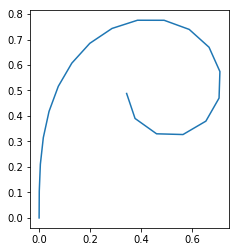

In [10]:
#clothoid with length = 2 m

t = linspace(0, 2, 20)
x, y = fresnel(t)
plt.plot(x, y)
plt.axes().set_aspect("equal")
plt.show()

In [11]:
a1 = np.column_stack((x,y))
a1.shape

(20, 2)

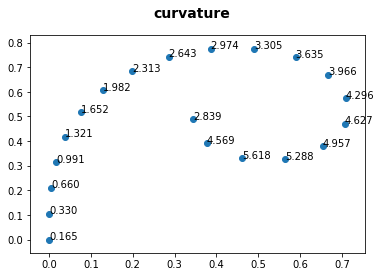

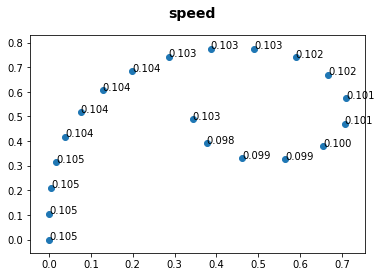

In [12]:
a1_path = Path(a1)
a1_path.plot_curvature() 
a1_path.plot_speed()
#this is the standard Euler's spiral, in which Curvature = 2*L. One can see the numeric error is very large

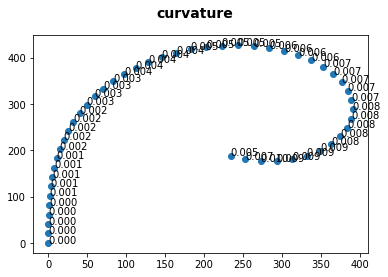

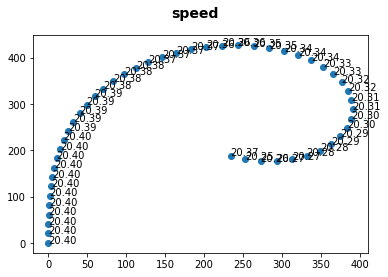

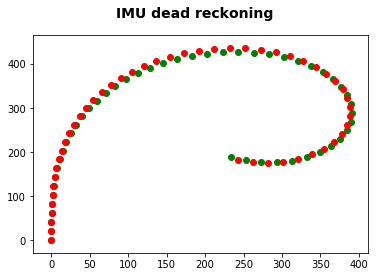

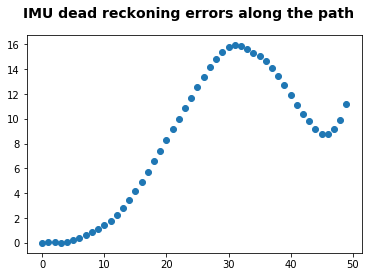

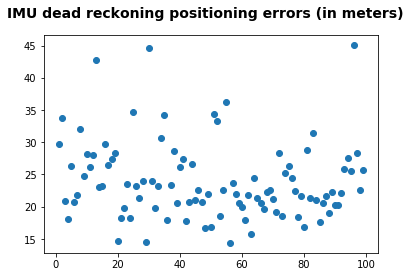

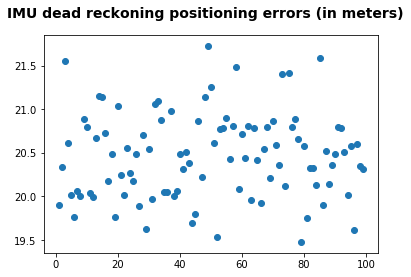

[19.897295069229845,
 20.334098131660411,
 21.556968713546681,
 20.609782991712784,
 20.011234111777444,
 19.758558811971408,
 20.064514192164605,
 19.999443378656348,
 20.88329303469537,
 20.796913868142752,
 20.04305202844267,
 19.995361354853753,
 20.6723655828918,
 21.152943723315396,
 21.138690891913132,
 20.72212796722766,
 20.179690764555989,
 20.488907410883542,
 19.765756150616699,
 21.032441092121246,
 20.239996547301413,
 20.013762196679064,
 20.552300768239132,
 20.267315413091019,
 20.182055765423438,
 20.491006959669576,
 19.885332981297296,
 20.703706129532062,
 19.628414337554123,
 20.545481502537346,
 19.967929650640428,
 21.055020156753127,
 21.091393473326416,
 20.88017581949368,
 20.055205665829014,
 20.045963524875301,
 20.975262998689168,
 20.005089697219415,
 20.065205129879445,
 20.484841983168113,
 20.312166917467028,
 20.508565995494482,
 20.388598450521737,
 19.695433505618045,
 19.797897614340599,
 20.862305106046961,
 20.219396342082462,
 21.143393544614597

In [13]:
#clothoid with length = 1000 m
#ending radius = 300 m
#https://en.wikipedia.org/wiki/Euler_spiral#Formulation

L_s = 1000
R_c = 300
scaling_factor_a = 1/np.sqrt(L_s * R_c)
t = linspace(0, 1000, 50)
t_scaled = t*scaling_factor_a
x, y = fresnel(t_scaled)
x_scaled = x/scaling_factor_a
y_scaled = y/scaling_factor_a
a2 = np.column_stack((x_scaled,y_scaled))
a2_path = Path(a2)
a2_path.plot_curvature()
a2_path.plot_speed()
a2_path.plot_IMU_simulation()
a2_path.plot_IMU_errors(co_var =0.05)
a2_path.plot_IMU_errors(co_var = 0.005)

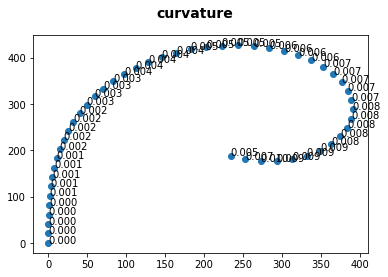

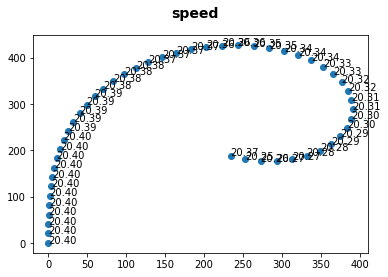

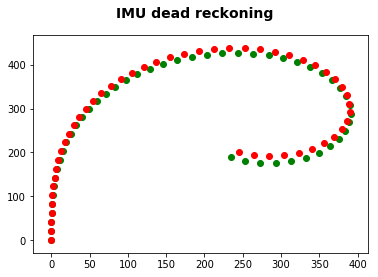

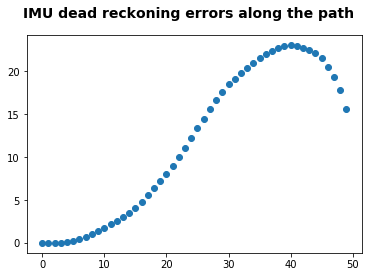

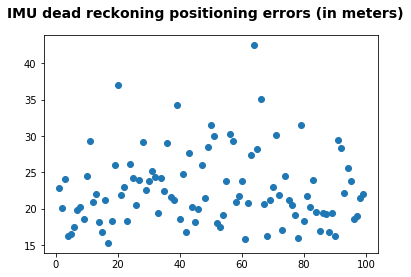

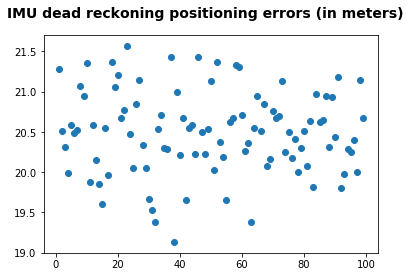

[21.280796858106065,
 20.507559825992033,
 20.307387986375193,
 19.989655071105695,
 20.581495594578151,
 20.491411695623661,
 20.51913441581442,
 21.077013585325734,
 20.952983193751532,
 21.359147973229014,
 19.881725954828013,
 20.586335268085008,
 20.156299610179282,
 19.849656067422337,
 19.599126886620628,
 20.553023643657738,
 19.964146331518354,
 21.363107399097917,
 21.057689184232199,
 21.208704403288358,
 20.678990665980283,
 20.767626246450881,
 21.563709201838677,
 20.477655845107154,
 20.049664483357919,
 20.850347645493343,
 21.151812958215213,
 20.343704438451191,
 20.0494795377994,
 19.669832474930026,
 19.527618631842802,
 19.378788952295046,
 20.539421915314527,
 20.716839208830855,
 20.302815818833601,
 20.29394158436946,
 21.430072620051433,
 19.135023810088654,
 20.998209377624121,
 20.212878791168734,
 20.676759976510649,
 19.660402378911371,
 20.544753968916556,
 20.58833118311194,
 20.222115854571008,
 21.428585846949947,
 20.498217489216703,
 20.23204239969923

In [14]:
#clothoid with length = 1000 m
#ending radius = 300 m
#https://en.wikipedia.org/wiki/Euler_spiral#Formulation

L_s = 1000
R_c = 300
sampling_freq = 50
clothoid_path = Clothoid(L_s, R_c, sampling_freq )
clothoid_path.plot_curvature()
clothoid_path.plot_speed()
clothoid_path.plot_IMU_simulation()
clothoid_path.plot_IMU_errors(co_var = 0.05)
clothoid_path.plot_IMU_errors(co_var = 0.005)

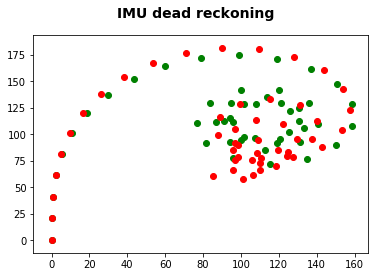

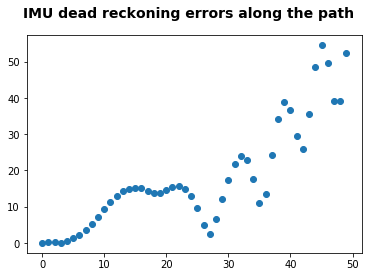

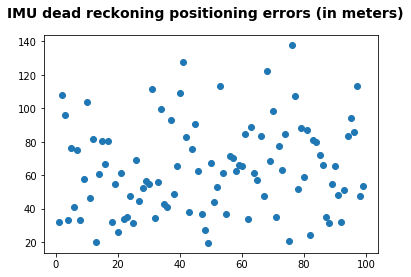

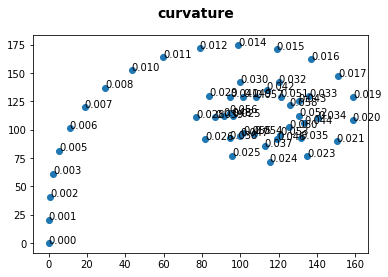

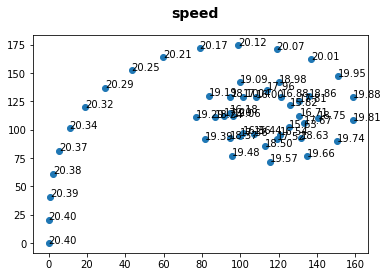

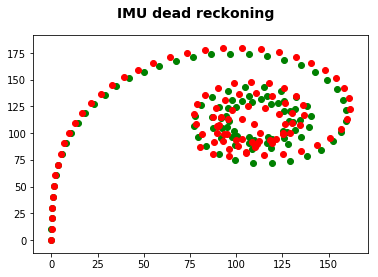

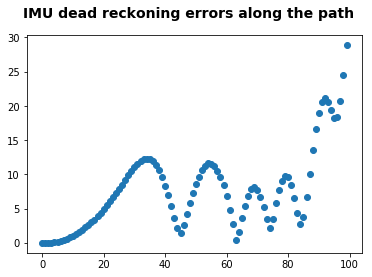

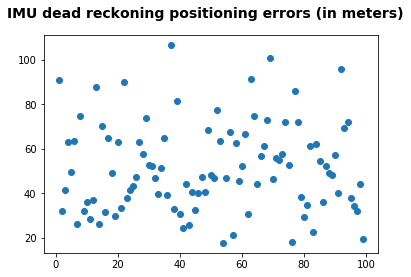

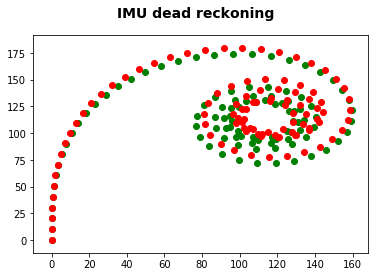

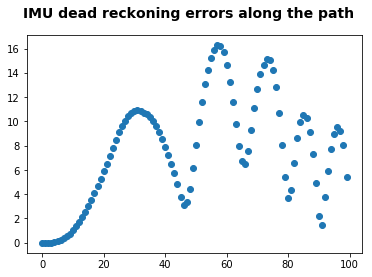

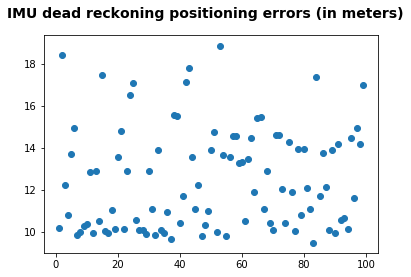

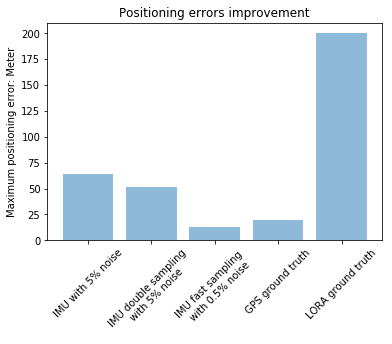

In [15]:
clothoid_path = Clothoid(1000, 50, 50 )
clothoid_path.plot_IMU_simulation()
max_errors = clothoid_path.plot_IMU_errors(co_var = 0.05)
clothoid_path.plot_curvature()
clothoid_path.plot_speed()

clothoid_path2 = Clothoid(1000, 50, 100)
clothoid_path2.plot_IMU_simulation()
max_errors_2 = clothoid_path2.plot_IMU_errors(co_var = 0.05)

clothoid_path2.plot_IMU_simulation()
max_errors_3 = clothoid_path2.plot_IMU_errors(co_var = 0.005)

algos = ('IMU with 5% noise', 'IMU double sampling\n with 5% noise', 'IMU fast sampling \n with 0.5% noise',"GPS ground truth", "LORA ground truth")
y_pos = np.arange(len(algos))
performance = [np.mean(max_errors), np.mean(max_errors_2), np.mean(max_errors_3), 20, 200]
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, algos, rotation=45)
#plt.set_xticklabels( , rotation=45 )
plt.ylabel('Maximum positioning error: Meter')
plt.title('Positioning errors improvement')
 
plt.show()

In [16]:
clothoid_path.a.shape[0]

50